# Final Project Notebook

## Task - Image Reconition
I have chosen the image recognition task for this final project

### Imports and Environment Setup

In [1]:
import sys
from pathlib import Path
import torch

ROOT = Path.cwd().parent
sys.path.insert(0, str(ROOT))

print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))

PyTorch version: 2.7.1+cu118
CUDA available: True
GPU: NVIDIA GeForce GTX 980 Ti


### Data Ingestion
We begin by downloading the dataset using the function download_mnist in the python file ingest.py located in the steps directory. The dataset is not stored in the repository.

In [2]:
from steps.ingest import download_mnist
data_dir = ROOT / "data"
download_mnist(data_dir=str(data_dir))
data_dir

PosixPath('/mnt/c/Users/jarla/Documents/DVAE26/DVAE26_final_project/data')

### Dataset Inspection and Sanity Checks
The number of images in the training set and test set is 60000 and 10000 respectively. The size of the images is 28x28. The labels are the integers ranging from 0 to 9.

In [3]:
from torchvision import datasets

train_raw = datasets.MNIST(root=str(data_dir), train=True, download=False)
test_raw = datasets.MNIST(root=str(data_dir), train=False, download=False)

print("Train samples:", len(train_raw))
print("Test samples:", len(test_raw))
print("Image size:", train_raw[0][0].size)
print("Unique labels:", sorted(set(train_raw.targets.tolist())))

Train samples: 60000
Test samples: 10000
Image size: (28, 28)
Unique labels: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


### Preprocessing and Augmentation
Next, the images from the downloaded dataset are transformed, augmented and loaded into DataLoaders.Data transformation was applied to convert raw MNIST images into normalized tensors suitable for neural network training. Pixel values were scaled and normalized using the dataset mean and standard deviation. In addition, data augmentation in the form of random rotations was applied to the training data to improve robustness to handwriting variation and reduce overfitting. No augmentation was applied to the test set to preserve evaluation integrity. The steps/train.py and steps/evaluate.py call get_dataloaders() function, which uses the get_transforms() function. The following code shows the augmentation and transformation being applied.

In [4]:
from src.data import get_transforms

train_tf = get_transforms(train=True)
test_tf = get_transforms(train=False)

train_tf, test_tf

(Compose(
     RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
     ToTensor()
     Normalize(mean=(0.1307,), std=(0.3081,))
 ),
 Compose(
     ToTensor()
     Normalize(mean=(0.1307,), std=(0.3081,))
 ))

### Visual Validation of Augmentation
The augmentation can be shown by 

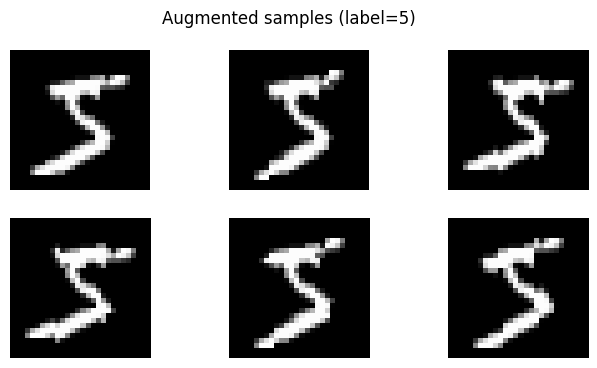

In [5]:
import matplotlib.pyplot as plt

imgs = [train_tf(train_raw[0][0]) for _ in range(6)]
label = train_raw[0][1]

plt.figure(figsize=(8,4))
for i, img in enumerate(imgs):
    plt.subplot(2,3,i+1)
    plt.imshow(img.squeeze(0), cmap="gray")
    plt.axis("off")
plt.suptitle(f"Augmented samples (label={label})")
plt.show()

### DataLoaders and Batch Shapes

In [6]:
from src.data import get_dataloaders

train_loader, test_loader = get_dataloaders(
    data_dir=str(data_dir),
    batch_size=64,
    num_workers=0,
)

images, labels = next(iter(train_loader))
print("Images shape:", images.shape)
print("Labels shape:", labels.shape)

Images shape: torch.Size([64, 1, 28, 28])
Labels shape: torch.Size([64])


### Model Instantiation and Forward Pass

In [7]:
from src.model import MNISTCNN

model = MNISTCNN()
logits = model(images)

print("Model output shape:", logits.shape)

Model output shape: torch.Size([64, 10])


### Training Step

In [8]:
from steps.train import train

weights_path = train(
    data_dir=str(data_dir),
    artifacts_dir=str(ROOT / "artifacts"),
    epochs=10,
    batch_size=64,
    num_workers=2,
)
weights_path

Epoch 10/10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:12<00:00, 74.03it/s, acc=0.9958, loss=0.0124]


PosixPath('/mnt/c/Users/jarla/Documents/DVAE26/DVAE26_final_project/artifacts/mnist_cnn.pt')

### Evaluation and Metrics

In [9]:
from steps.evaluate import evaluate

metrics_path = evaluate(
    data_dir=str(data_dir),
    artifacts_dir=str(ROOT / "artifacts"),
    weights_path=str(ROOT / "artifacts" / "mnist_cnn.pt"),
)
metrics_path

PosixPath('/mnt/c/Users/jarla/Documents/DVAE26/DVAE26_final_project/artifacts/metrics.json')

### Results

In [10]:
import json
from PIL import Image

with open(metrics_path) as f:
    metrics = json.load(f)

metrics

{'test_accuracy': 0.9926999807357788,
 'test_macro_precision': 0.9927056303253525,
 'test_macro_recall': 0.9926066679181982,
 'example_count': 10000,
 'weights_path': '/mnt/c/Users/jarla/Documents/DVAE26/DVAE26_final_project/artifacts/mnist_cnn.pt',
 'device': 'cuda'}

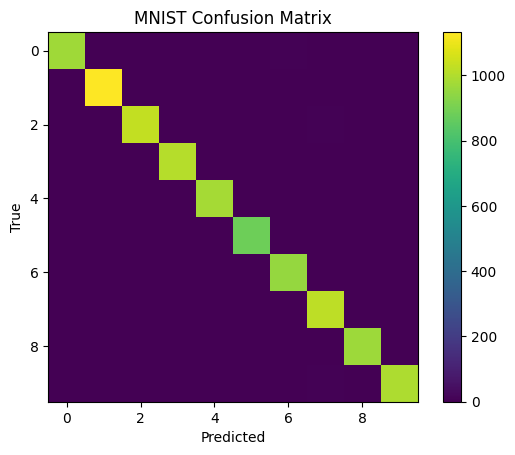

In [11]:
Image.open(ROOT / "artifacts" / "confusion_matrix.png")

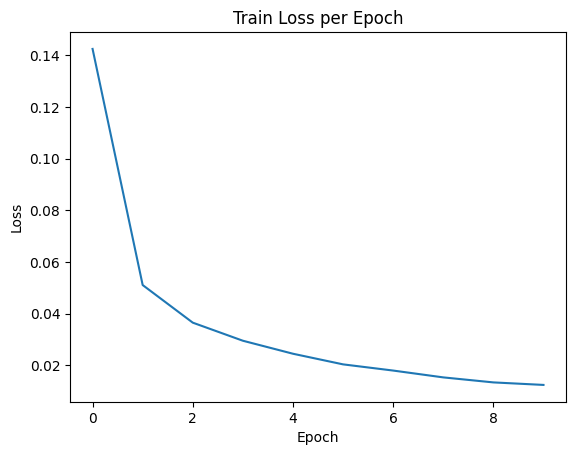

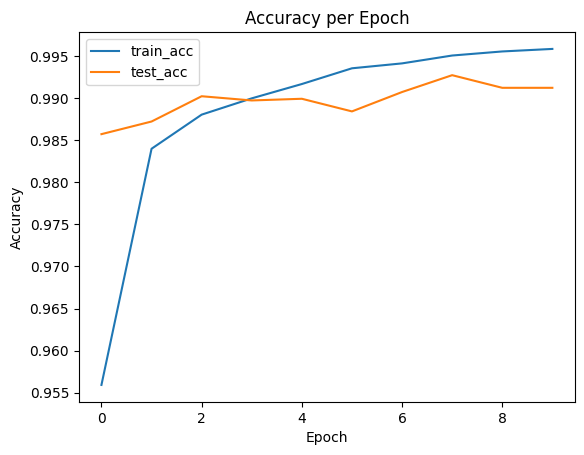

In [12]:
import json
import matplotlib.pyplot as plt
from pathlib import Path

hist = json.loads(Path(ROOT / "artifacts" / "train_history.json").read_text(encoding="utf-8"))
h = hist["history"]

plt.figure()
plt.plot(h["train_loss"])
plt.title("Train Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

plt.figure()
plt.plot(h["train_acc"], label="train_acc")
plt.plot(h["test_acc"], label="test_acc")
plt.title("Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()